Module - CIS7017 Dissertation
Student ID - #20275320

In [1]:
# Import all relevant libraries
import pandas as pd
# from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [2]:
# Load the dataset
df = pd.read_csv('utah_traffic_accidents.csv')

# Convert time to epoc timstamp for numerical calculations.
df['Start_Time'] = pd.to_datetime(df['Start_Time'])
df['End_Time'] = pd.to_datetime(df['End_Time'])
df['Start_Time'] = (df['Start_Time'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
df['End_Time'] = (df['End_Time'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
df

,Severity,Start_Time,End_Time,Geo_lat,Geo_lng,Distance,City,Temperature,Humidity,Pressure,...,Station,Stop,Traffic_Signal,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Altitude,Time_Duration,Snowfall
0,1,1662630499,1662634812,40.781876,-111.910858,0.000,Salt Lake City,86.0,25.0,25.72,...,False,False,False,Day,Day,Day,Day,1293.0,4313.0,0.0
1,2,1662633085,1662634849,40.297562,-111.725700,0.000,Orem,82.0,30.0,25.51,...,False,False,False,Day,Day,Day,Day,1408.0,1764.0,0.0
2,1,1662619798,1662622017,38.521690,-109.496834,0.000,Moab,64.0,23.0,25.40,...,False,False,False,Night,Day,Day,Day,1406.0,2219.0,0.0
3,2,1662627051,1662628783,40.769329,-111.899712,0.000,Salt Lake City,82.0,27.0,25.75,...,False,False,True,Day,Day,Day,Day,1310.0,1732.0,0.0
4,1,1662627360,1662631074,40.837925,-111.915627,0.000,North Salt Lake,82.0,27.0,25.75,...,False,False,False,Day,Day,Day,Day,1303.0,3714.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66177,2,1566584280,1566589018,41.190640,-112.049030,0.037,Ogden,81.0,18.0,25.46,...,False,False,False,Day,Day,Day,Day,1313.0,4738.0,0.0
66178,2,1566585720,1566589320,40.725580,-112.204935,0.019,Magna,85.0,18.0,25.64,...,False,False,False,Day,Day,Day,Day,1289.0,3600.0,0.0
66179,2,1566585720,1566589320,40.725662,-112.204579,0.020,Magna,85.0,18.0,25.64,...,False,False,False,Day,Day,Day,Day,1289.0,3600.0,0.0
66180,2,1566586740,1566590280,41.209522,-111.948491,0.028,Ogden,80.0,20.0,25.45,...,False,False,False,Day,Day,Day,Day,1383.0,3540.0,0.0


# Definition of target variable -  Kernel Density Estimation 

In [ ]:
from scipy.stats import gaussian_kde

# Calculate KDE values for each location
values = np.vstack([df['Geo_lat'], df['Geo_lng']])
kde = gaussian_kde(values)(values)

# assuming that we've already calculated the KDE values for each location
df['KDE_Value'] = kde

# Defining percentile-based thresholds
# let's consider a three-category system (low, medium, high) for simplicity
percentiles = [25]  # percentiles
# percentiles = [33,66]  # percentiles
tau = np.percentile(df['KDE_Value'], percentiles)

# Define the target variable 'y' based on KDE values and thresholds
def assign_label(z, thresholds):
    C = len(thresholds)  # The constant C is the number of thresholds
    k = next((x for x in range(C) if z >= thresholds[x]), C)  
    return C - k

# Apply the function to assign labels to each location
df['Hotspot_Intensity'] = df['KDE_Value'].apply(lambda z: assign_label(z, tau))

df.head()

In [3]:
# Different domain based approach to define target variable depending on the weather and sevierity factors 

# Severity mapping
severity_mapping = {1: 'low', 2: 'low', 3: 'medium', 4: 'high'} # Depending on the initial EDA, 1 and 2 were considered as a one level.
df['Severity_Level'] = df['Severity'].map(severity_mapping)

# Weather conditions mapping
weather_conditions = {
    'Wintry Mix': 'poor',
    'Thunderstorms and Rain': 'poor',
    'Thunderstorm': 'poor',
    'Thunder in the Vicinity': 'moderate',
    'Thunder / Windy': 'moderate',
    'Thunder': 'moderate',
    'T-Storm / Windy': 'moderate',
    'T-Storm': 'moderate',
    'Squalls / Windy': 'moderate',
    'Snow and Thunder / Windy': 'poor',
    'Snow / Windy': 'poor',
    'Snow': 'poor',
    'Smoke / Windy': 'moderate',
    'Smoke': 'moderate',
    'Small Hail': 'moderate',
    'Showers in the Vicinity': 'moderate',
    'Scattered Clouds': 'good',
    'Rain / Windy': 'moderate',
    'Rain': 'moderate',
    'Patches of Fog': 'poor',
    'Partly Cloudy / Windy': 'good',
    'Partly Cloudy': 'good',
    'Overcast': 'moderate',
    'N/A Precipitation': 'good',
    'Mostly Cloudy / Windy': 'good',
    'Mostly Cloudy': 'good',
    'Mist': 'moderate',
    'Light Thunderstorms and Rain': 'moderate',
    'Light Snow with Thunder': 'moderate',
    'Light Snow / Windy': 'moderate',
    'Light Snow': 'moderate',
    'Light Rain with Thunder': 'moderate',
    'Light Rain Shower': 'moderate',
    'Light Rain / Windy': 'moderate',
    'Light Rain': 'moderate',
    'Light Freezing Rain': 'poor',
    'Light Drizzle': 'moderate',
    'Heavy Thunderstorms and Rain': 'poor',
    'Heavy T-Storm / Windy': 'poor',
    'Heavy T-Storm': 'poor',
    'Heavy Snow / Windy': 'poor',
    'Heavy Snow': 'poor',
    'Heavy Rain': 'poor',
    'Haze / Windy': 'moderate',
    'Haze': 'moderate',
    'Fog / Windy': 'poor',
    'Fog': 'poor',
    'Fair / Windy': 'good',
    'Fair': 'good',
    'Drizzle': 'moderate',
    'Cloudy / Windy': 'moderate',
    'Cloudy': 'moderate',
    'Clear': 'good',
    'Blowing Snow / Windy': 'poor',
    'Blowing Dust / Windy': 'moderate',
    'Blowing Dust': 'moderate'
}

df['Weather_Risk'] = df['Weather_Condition'].map(weather_conditions)

# Check if there are NaN values after mapping
# print("Severity_Level:", df['Severity_Level'].isna().sum())
# print("Weather_Risk:", df['Weather_Risk'].isna().sum())

# Assign numerical weights to Severity_Level and Weather_Risk for calculation
weights_severity = {'low': 1, 'medium': 2, 'high': 3}
weights_weather = {'good': 1, 'moderate': 2, 'poor': 3}

df['Severity_Score'] = df['Severity_Level'].map(weights_severity)
df['Weather_Score'] = df['Weather_Risk'].map(weights_weather)

# Composite Score calculation
df['Composite_Score'] = df['Severity_Score'] + df['Weather_Score']

# print(df['Composite_Score'].describe())

# Here we will set the thresholds based on quartiles or other methods
# For simplicity, I'll use fixed thresholds here but we can adjust them based on the output from the .describe() method or quartiles
new_thresholds = {
    'low': df['Composite_Score'].quantile(0.33),  # Adjusted for 3 categories
    'medium': df['Composite_Score'].quantile(0.66),  # Adjusted for 3 categories
}

# Create bins for the cut for three categories
new_bins = [-float('inf'), new_thresholds['low'], new_thresholds['medium'], float('inf')]
new_labels = ['low', 'medium', 'high']  # Three categories

# Label data based on composite score
df['Hotspot_Intensity'] = pd.cut(df['Composite_Score'], bins=new_bins, labels=new_labels, include_lowest=True)

# Convert the categorical labels to a numerical form if needed for ML models
new_label_mapping = {'low': 0, 'medium': 1, 'high': 2}
df['Hotspot_Target'] = df['Hotspot_Intensity'].map(new_label_mapping)

# Drop unrelated columns
df = df.drop(columns=['Composite_Score', 'Severity_Score', 'Weather_Score', 'Severity_Level', 'Weather_Risk', 'Weather_Condition', 'Hotspot_Intensity'])

df['Hotspot_Target'] = df['Hotspot_Target'].astype(int)
df

,Severity,Start_Time,End_Time,Geo_lat,Geo_lng,Distance,City,Temperature,Humidity,Pressure,...,Stop,Traffic_Signal,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Altitude,Time_Duration,Snowfall,Hotspot_Target
0,1,1662630499,1662634812,40.781876,-111.910858,0.000,Salt Lake City,86.0,25.0,25.72,...,False,False,Day,Day,Day,Day,1293.0,4313.0,0.0,0
1,2,1662633085,1662634849,40.297562,-111.725700,0.000,Orem,82.0,30.0,25.51,...,False,False,Day,Day,Day,Day,1408.0,1764.0,0.0,0
2,1,1662619798,1662622017,38.521690,-109.496834,0.000,Moab,64.0,23.0,25.40,...,False,False,Night,Day,Day,Day,1406.0,2219.0,0.0,0
3,2,1662627051,1662628783,40.769329,-111.899712,0.000,Salt Lake City,82.0,27.0,25.75,...,False,True,Day,Day,Day,Day,1310.0,1732.0,0.0,0
4,1,1662627360,1662631074,40.837925,-111.915627,0.000,North Salt Lake,82.0,27.0,25.75,...,False,False,Day,Day,Day,Day,1303.0,3714.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66177,2,1566584280,1566589018,41.190640,-112.049030,0.037,Ogden,81.0,18.0,25.46,...,False,False,Day,Day,Day,Day,1313.0,4738.0,0.0,0
66178,2,1566585720,1566589320,40.725580,-112.204935,0.019,Magna,85.0,18.0,25.64,...,False,False,Day,Day,Day,Day,1289.0,3600.0,0.0,0
66179,2,1566585720,1566589320,40.725662,-112.204579,0.020,Magna,85.0,18.0,25.64,...,False,False,Day,Day,Day,Day,1289.0,3600.0,0.0,0
66180,2,1566586740,1566590280,41.209522,-111.948491,0.028,Ogden,80.0,20.0,25.45,...,False,False,Day,Day,Day,Day,1383.0,3540.0,0.0,0


In [ ]:
# # sns.countplot(data=df, x='KDE_Value')
# # plt.title('KDE Value Distribution')
# # plt.show()
# 
# # using quartiles as thresholds to categorize the KDE values
# sns.histplot(df['KDE_Value'], kde=True)
# plt.show()
# 
# # Calculate quartiles
# Q1 = df['KDE_Value'].quantile(0.25)
# Q2 = df['KDE_Value'].quantile(0.50)
# Q3 = df['KDE_Value'].quantile(0.75)
# 
# 
# conditions = [
#     (df['KDE_Value'] <= Q1),
#     (df['KDE_Value'] > Q1) & (df['KDE_Value'] <= Q2),
#     (df['KDE_Value'] > Q2) & (df['KDE_Value'] <= Q3),
#     (df['KDE_Value'] > Q3)
# ]
# 
# # Assign labels based on these conditions
# labels = ['low', 'medium-low', 'medium-high', 'high']
# df['Hotspot_Intensity'] = np.select(conditions, labels)


## Map for hotspot intensity categories

In [ ]:
import folium

utah_center = [39.3210, -111.0937] #approximate coordinates of Utah
map = folium.Map(location=utah_center, zoom_start=6, tiles='OpenStreetMap')

# Define colors for different hotspot categories
colors = {0: '#ffc300', 1: '#e3611c', 2: '#900c3f'}

# Add points to the map
for idx, row in df.iterrows():
    folium.CircleMarker(
        location=(row['Geo_lat'], row['Geo_lng']),
        radius=1,
        color=colors[row['Hotspot_Target']],
        fill=True,
        fill_color=colors[row['Hotspot_Target']],
        fill_opacity=0.7,
        popup=f"Hotspot Category: {row['Hotspot_Target']}"  # Popup text on click
    ).add_to(map)

# Create a legend as an HTML element
legend_html = '''
<div style="position: fixed; 
     top: 50px; right: 50px; width: 150px; height: 90px; 
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color: white; opacity: 0.9;
     ">&nbsp; Hotspot Categories <br>
     &nbsp; Low: &nbsp; <i class="fa fa-circle fa-1x" style="color:#ffc300"></i><br>
     &nbsp; Medium: &nbsp; <i class="fa fa-circle fa-1x" style="color:#e3611c"></i><br>
     &nbsp; High: &nbsp; <i class="fa fa-circle fa-1x" style="color:#900c3f"></i>
</div>
'''
map.get_root().html.add_child(folium.Element(legend_html))
map.save('utah_hotspots.html')

# Display the map
map


# 1. Apply Random Forest regressor

## 1.1 Validate features for classifiers

In [4]:
# Split the data into training and testing sets
X = df.drop(['Hotspot_Target'], axis=1)
y = df['Hotspot_Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

categorical_features = [col for col in X_train.columns if X_train[col].dtype == "object"]

good_col_label = [col for col in categorical_features if
            set(X_train[col]) == set(X_test[col])]
bad_col_label = list(set(categorical_features) - set(good_col_label))

label_X_train = X_train.drop(bad_col_label, axis=1)
label_X_test = X_test.drop(bad_col_label, axis=1)

print("Good columns : ", good_col_label)
print("Bad columns : ", bad_col_label)

# "City" has to be removed because it contains a wide range of values that could cause problem when splitting the train/test data
df = df.drop(columns=['City'], axis=1)

Good columns :  ['Wind_Direction', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']
Bad columns :  ['City']


## 1.2 Run Random Forest

In [6]:
# columns should be encoded for the model
categorical_features = ['Wind_Direction', 'Sunrise_Sunset',
                        'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']

# Create a transformer for one-hot encoding
column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # This specifies that non-specified columns should be passed through without transformation
)

# Apply the transformer to feature matrix
X_encoded = column_transformer.fit_transform(df.drop(['Hotspot_Target'], axis=1))

y = df['Hotspot_Target']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
rf = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
rf.fit(X_train, y_train)

# Make prediction on the testing data
y_pred = rf.predict(X_test)

# Classification Report
print(classification_report(y_pred, y_test))

#Confusion metrix
print("-------- Confusion metrix -------- \n")
from sklearn.metrics import confusion_matrix
conf_mat_rf = confusion_matrix(y_test, y_pred)
print(conf_mat_rf)

              precision    recall  f1-score   support

           0       0.98      0.88      0.92      9093
           1       0.72      0.87      0.79      3384
           2       0.74      0.96      0.84       760

    accuracy                           0.88     13237
   macro avg       0.81      0.90      0.85     13237
weighted avg       0.90      0.88      0.89     13237

-------- Confusion metrix -------- 

[[7995  200    0]
 [1087 2944   32]
 [  11  240  728]]


## 1.3 Run Feature Importance

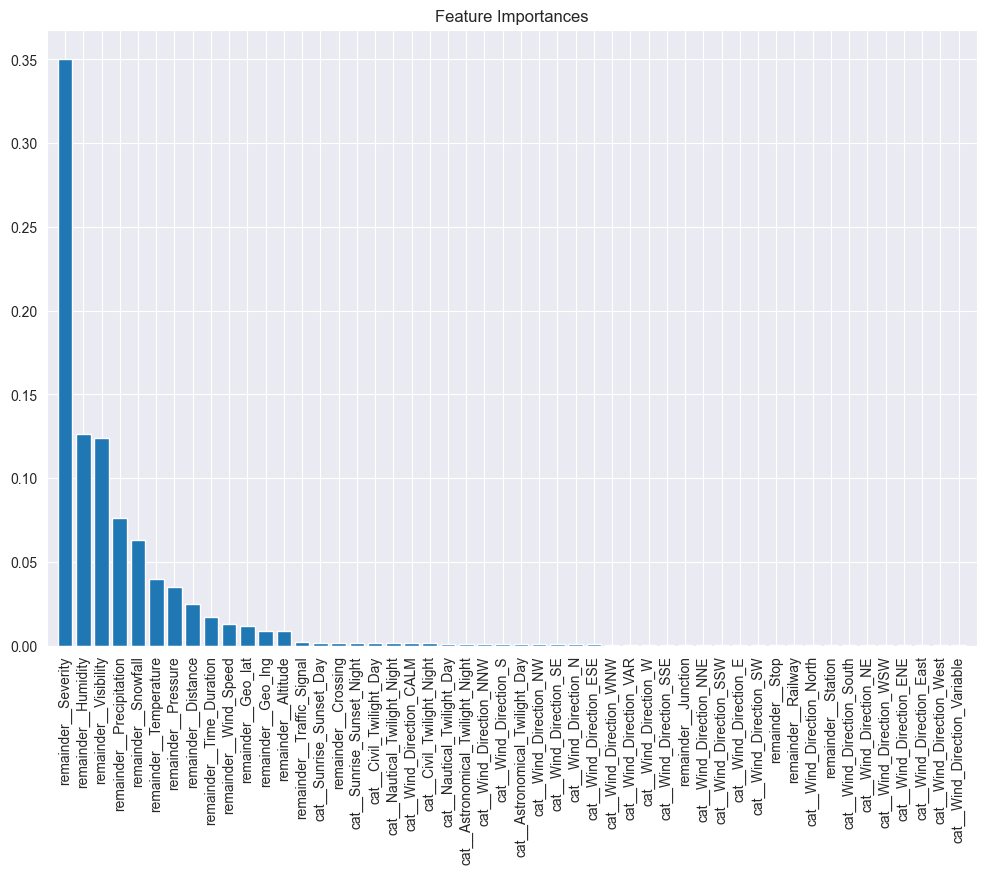

In [7]:
# Get numerical feature importances
importances = rf.feature_importances_

# Get the indices and Map indices to feature names
indices = np.argsort(importances)[::-1]
feature_names = column_transformer.get_feature_names_out()
sorted_feature_names = [feature_names[i] for i in indices]
sorted_importances = importances[indices]

# exclude from the plot
features_to_exclude = ['remainder__Start_Time', 'remainder__End_Time']

# Filter out the features to exclude
filtered_feature_names = []
filtered_importances = []
for feature_name, importance in zip(sorted_feature_names, sorted_importances):
    if feature_name not in features_to_exclude:
        filtered_feature_names.append(feature_name)
        filtered_importances.append(importance)

# Plot the feature importances of the forest for the remaining features
plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.bar(range(len(filtered_feature_names)), filtered_importances)
plt.xticks(range(len(filtered_feature_names)), filtered_feature_names, rotation=90)
plt.xlim([-1, len(filtered_feature_names)])
plt.show()


In [ ]:
# Hyperparameter optimization for Random Forest
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider at every split
    'max_depth': [None, 10, 20, 30],  # Maximum number of levels in tree
    'bootstrap': [True, False]  # Method of selecting samples for training each tree
}
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
best_rf = grid_search.best_estimator_

# Make predictions with the best model
y_pred = best_rf.predict(X_test)
print(classification_report(y_test, y_pred))

# 2. Apply XGBoost

## 2.2 Run XGBoost

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      8195
           1       0.89      0.82      0.86      4063
           2       0.92      0.84      0.88       979

    accuracy                           0.91     13237
   macro avg       0.91      0.88      0.89     13237
weighted avg       0.91      0.91      0.91     13237

-------- Confusion metrix -------- 

[[7951  244    0]
 [ 658 3332   73]
 [   8  149  822]]


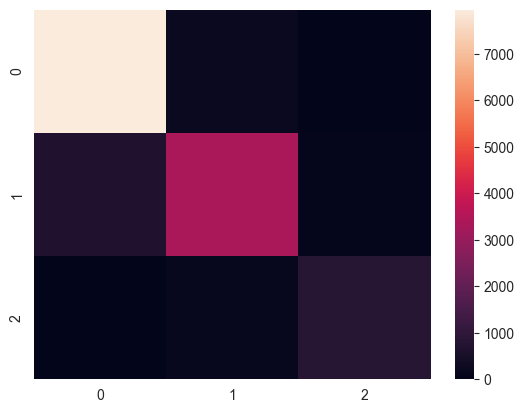

In [8]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Define which columns should be encoded
categorical_features = ['Wind_Direction', 'Sunrise_Sunset',
                        'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']

# Create a transformer for one-hot encoding
column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# Apply the transformer to feature matrix
X_encoded = column_transformer.fit_transform(df.drop(['Hotspot_Target'], axis=1))
y = df['Hotspot_Target']

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

#Confusion metrix
print("-------- Confusion metrix -------- \n")
from sklearn.metrics import confusion_matrix
conf_mat_xg = confusion_matrix(y_test, y_pred)
print(conf_mat_xg)

sns.heatmap(conf_mat_xg)
plt.show()

## 2.2 feature importances

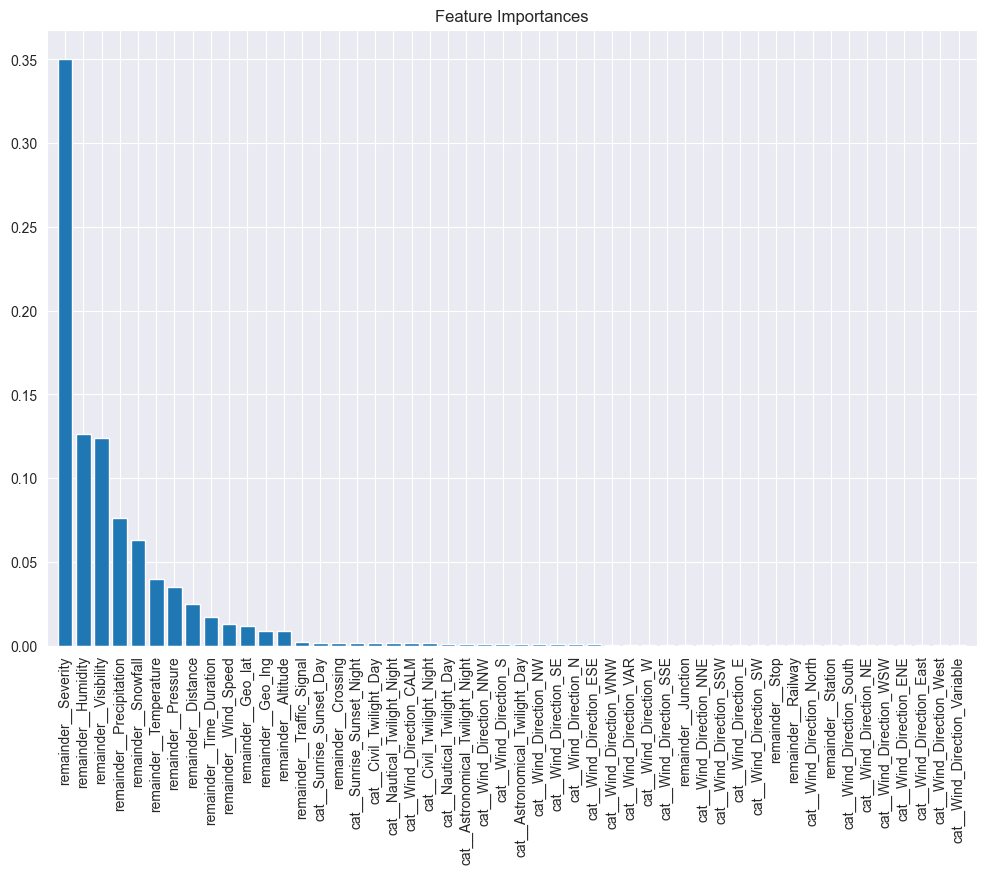

In [9]:
# Get numerical feature importances
importances = rf.feature_importances_

# Get the indices and Map indices to feature names
indices = np.argsort(importances)[::-1]
feature_names = column_transformer.get_feature_names_out()
sorted_feature_names = [feature_names[i] for i in indices]
sorted_importances = importances[indices]

# exclude from the plot
features_to_exclude = ['remainder__Start_Time', 'remainder__End_Time']

# Filter out the features to exclude
filtered_feature_names = []
filtered_importances = []
for feature_name, importance in zip(sorted_feature_names, sorted_importances):
    if feature_name not in features_to_exclude:
        filtered_feature_names.append(feature_name)
        filtered_importances.append(importance)

# Plot the feature importances of the forest for the remaining features
plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.bar(range(len(filtered_feature_names)), filtered_importances)
plt.xticks(range(len(filtered_feature_names)), filtered_feature_names, rotation=90)
plt.xlim([-1, len(filtered_feature_names)])
plt.show()


# 3. Apply SVM

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Define which columns should be encoded
categorical_features = ['Wind_Direction', 'Sunrise_Sunset',
                        'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']

# Create a transformer for one-hot encoding and scaling numerical features
column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder=StandardScaler(with_mean=False)  # Scale other variables without centering
)

# Apply the transformer to feature matrix
X_encoded = column_transformer.fit_transform(df.drop(['Hotspot_Target'], axis=1))
y = df['Hotspot_Target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Initialize and train the SVM model
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train, y_train)

# Make prediction on the testing data
y_pred = svm_model.predict(X_test)

# Classification Report
print(classification_report(y_test, y_pred))

#Confusion metrix
print("-------- Confusion metrix -------- \n")
from sklearn.metrics import confusion_matrix
conf_mat_svm = confusion_matrix(y_test, y_pred)
print(conf_mat_svm)

sns.heatmap(conf_mat_svm)
plt.show()


# 4. Plotting Confusion Matrix summary 

In [ ]:
# Plotting confusion matrix summary 
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

sns.heatmap(conf_mat_rf, annot=True, fmt="d", cmap="Blues", ax=ax[0])
ax[0].set_title("Confusion Matrix for Random Forest")
ax[0].set_xlabel("Predicted class")
ax[0].set_ylabel("True class")

sns.heatmap(conf_mat_xg, annot=True, fmt="d", cmap="Greens", ax=ax[1])
ax[1].set_title("Confusion Matrix for XGBoost")
ax[1].set_xlabel("Predicted class")
ax[1].set_ylabel("True class")

sns.heatmap(conf_mat_svm, annot=True, fmt="d", cmap="Purples", ax=ax[2])
ax[2].set_title("Confusion Matrix for SVM")
ax[2].set_xlabel("Predicted class")
ax[2].set_ylabel("True class")

plt.tight_layout()
plt.show()

# 5. Spatial autocorrelation

C:\Users\ishar\AppData\Local\Programs\Python\Python311\Lib\site-packages\libpysal\weights\weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 845 disconnected components.
  warnings.warn(message)


Moran's I: 0.1963804520788167 
p-value: 0.001, 
Expected I: -1.679261125104954e-05, 
Variance: 3.3848186785851667e-06, 
z-score: 106.74995145545462


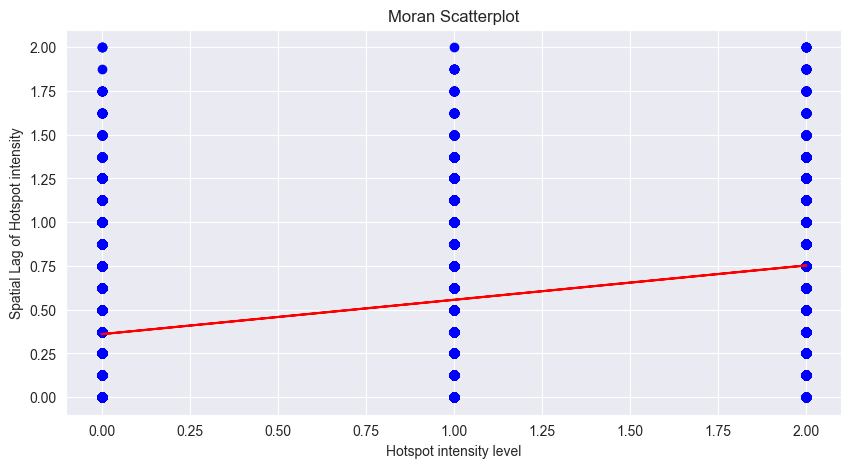

In [45]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
from libpysal.weights import Queen
from libpysal import weights
from esda.moran import Moran
from scipy import stats

# Identify numerical features
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Identify categorical features
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

 # Removing categorical features as Spatial autocorrelation can no be run with categorical features
df = df.drop(categorical_features, axis=1)

# Convering dataset to a geo-panda dataset
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Geo_lng, df.Geo_lat))

# Create spatial weight matrix
w = weights.KNN.from_dataframe(gdf, k=8)
w.transform = 'r'

# Compute Moran's I
y = gdf['Hotspot_Target'].values
moran = Moran(y, w)

# Calculate z-score
moran_I = moran.I
expected_I = moran.EI
variance_I = moran.VI_norm
z_score = (moran_I - expected_I) / np.sqrt(variance_I)

# Calculate the p-value from the z-score
p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))
print(f"Moran's I: {moran.I} \np-value: {moran.p_sim}, \nExpected I: {expected_I}, \nVariance: {variance_I}, \nz-score: {z_score}")

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
lag_y = weights.lag_spatial(w, y)
ax.scatter(y, lag_y, color='blue')

# Fit line
b, a = np.polyfit(y, lag_y, 1)
ax.plot(y, a + b*y, 'r')
plt.title('Moran Scatterplot')
plt.xlabel('Hotspot intensity level')
plt.ylabel('Spatial Lag of Hotspot intensity')
plt.show()


# 6. Getis-Ord Gi* statistic

C:\Users\ishar\AppData\Local\Programs\Python\Python311\Lib\site-packages\libpysal\weights\weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 845 disconnected components.
  warnings.warn(message)
C:\Users\ishar\AppData\Local\Programs\Python\Python311\Lib\site-packages\esda\getisord.py:615: UserWarning: Gi* requested, but (a) weights are already row-standardized, (b) no weights are on the diagonal, and (c) no default value supplied to star. Assuming that the self-weight is equivalent to the maximum weight in the row. To use a different default (like, .5), set `star=.5`, or use libpysal.weights.fill_diagonal() to set the diagonal values of your weights matrix and use `star=None` in Gi_Local.
  warnings.warn(


GI* Z-scores: [ 0.35187958  0.35187958  0.70937514 ... -0.54185932 -0.54185932
 -0.54185932]
GI* p-values: [0.069 0.153 0.009 ... 0.115 0.115 0.115]


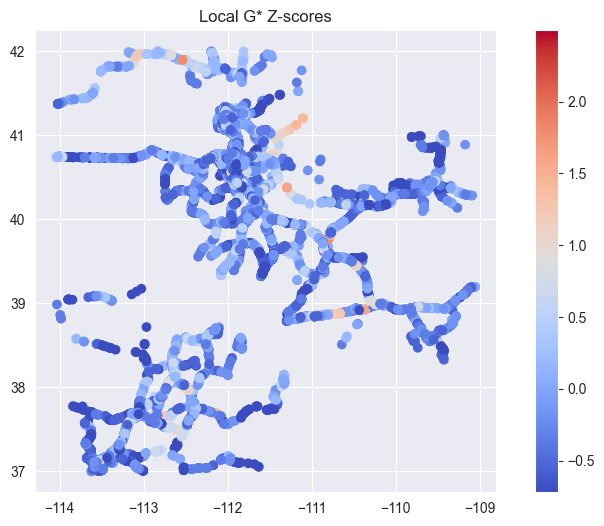

In [51]:
import geopandas as gpd
import numpy as np
from libpysal.weights import KNN
from esda.getisord import G_Local

# GeoDataFrame from longitude and latitude columns
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Geo_lng, df.Geo_lat))

# Create spatial weights using KNN
w = KNN.from_dataframe(gdf, k=8)
w.transform = 'r'  # Row-standardize the weights

# Calculate the Getis-Ord Gi* statistic
gi_star = G_Local(gdf['Hotspot_Target'], w, star=True, transform='r')

# Printing the results
print("GI* Z-scores:", gi_star.Zs)
print("GI* p-values:", gi_star.p_sim)

# Optional: Plotting the GI* Z-scores for visual inspection
import matplotlib.pyplot as plt

gdf['gi_z_scores'] = gi_star.Zs

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
gdf.plot(column='gi_z_scores', cmap='coolwarm', legend=True, ax=ax)
plt.title('Local G* Z-scores')
plt.show()


In [68]:
import folium
import branca

# Create a map centered around the average location
center_lat, center_lon = gdf['Geo_lat'].mean(), gdf['Geo_lng'].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=7)

# Define the color scale
# color_hex = ['#ffc300', '#f1920e', '#e3611c', '#c70039', '#900c3f', '#5a1846']
color_hex = ['#a2d7d8', '#bfe1bf', '#ededea', '#fcd059', '#de5842']
color_scale = branca.colormap.LinearColormap(
    color_hex,
    vmin=min(gdf['gi_z_scores']),
    vmax=max(gdf['gi_z_scores'])
)

# Add a color scale bar
color_scale.caption = 'Z-score Color Scale'
color_scale.add_to(m)

# Add points with colors based on Z-score
for _, row in gdf.iterrows():
    color = color_scale(row['gi_z_scores'])
    folium.CircleMarker(
        location=[row['Geo_lat'], row['Geo_lng']],
        radius=1,
        color=color,
        fill=True,
        fill_color=color,
        popup=f"Z-score: {row['gi_z_scores']:.2f}",  # Display Z-score on click
        fill_opacity=0.7
    ).add_to(m)

# Display the map
m.save('outputmaps/Getis-Ord_map.html')  # Save to HTML file or simply display in a Jupyter notebook


In [63]:
# Export final datafile
# gdf.to_file('outputmaps/final_dataset.geojson', driver='GeoJSON')
gdf.to_csv('outputmaps/final_dataset.csv', index=False)

In [62]:
gdf

,Severity,Start_Time,End_Time,Geo_lat,Geo_lng,Distance,Temperature,Humidity,Pressure,Visibility,...,Junction,Railway,Station,Stop,Traffic_Signal,Altitude,Time_Duration,Hotspot_Target,geometry,gi_z_scores
0,1,1662630499,1662634812,40.781876,-111.910858,0.000,86.0,25.0,25.72,10.0,...,False,False,False,False,False,1293.0,4313.0,0.0,POINT (-111.91086 40.78188),0.351880
1,2,1662633085,1662634849,40.297562,-111.725700,0.000,82.0,30.0,25.51,10.0,...,False,False,False,False,False,1408.0,1764.0,0.0,POINT (-111.72570 40.29756),0.351880
2,1,1662619798,1662622017,38.521690,-109.496834,0.000,64.0,23.0,25.40,10.0,...,False,False,False,False,False,1406.0,2219.0,0.0,POINT (-109.49683 38.52169),0.709375
3,2,1662627051,1662628783,40.769329,-111.899712,0.000,82.0,27.0,25.75,10.0,...,False,True,False,False,True,1310.0,1732.0,0.0,POINT (-111.89971 40.76933),-0.720607
4,1,1662627360,1662631074,40.837925,-111.915627,0.000,82.0,27.0,25.75,10.0,...,True,False,False,False,False,1303.0,3714.0,0.0,POINT (-111.91563 40.83792),1.245618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59546,2,1566584280,1566589018,41.190640,-112.049030,0.037,81.0,18.0,25.46,10.0,...,False,False,False,False,False,1313.0,4738.0,0.0,POINT (-112.04903 41.19064),-0.363112
59547,2,1566585720,1566589320,40.725580,-112.204935,0.019,85.0,18.0,25.64,10.0,...,False,False,False,False,False,1289.0,3600.0,0.0,POINT (-112.20494 40.72558),-0.541859
59548,2,1566585720,1566589320,40.725662,-112.204579,0.020,85.0,18.0,25.64,10.0,...,False,False,False,False,False,1289.0,3600.0,0.0,POINT (-112.20458 40.72566),-0.541859
59549,2,1566586740,1566590280,41.209522,-111.948491,0.028,80.0,20.0,25.45,10.0,...,False,False,False,False,False,1383.0,3540.0,0.0,POINT (-111.94849 41.20952),-0.541859
